In [1]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [7]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT DISTINCT f.title, f.length, f.rating, c.name AS category, round(AVG(p.amount),2) AS avg_amount
FROM film f
LEFT JOIN inventory i ON f.film_id = i.film_id
LEFT JOIN rental r ON i.inventory_id = r.inventory_id
LEFT JOIN payment p ON r.rental_id = p.rental_id
LEFT JOIN film_category fc ON f.film_id = fc.film_id
LEFT JOIN category c ON fc.category_id = c.category_id
GROUP BY f.title, f.length, f.rating, c.name;'''

data1 = pd.read_sql_query(query, engine)
data1.head()

,title,length,rating,category,avg_amount
0,ACADEMY DINOSAUR,86,PG,Documentary,1.60
1,ACE GOLDFINGER,48,G,Horror,7.56
2,ADAPTATION HOLES,50,NC-17,Documentary,3.16
3,AFFAIR PREJUDICE,117,G,Horror,3.99
4,AFRICAN EGG,130,G,Family,4.32


In [8]:
query = '''SELECT f.title,
       CASE WHEN EXISTS (SELECT 1
                         FROM inventory i
                         JOIN rental r ON i.inventory_id = r.inventory_id
                         WHERE f.film_id = i.film_id
                           AND MONTH(r.rental_date) = 5)
           THEN 'Yes'
           ELSE 'No'
       END AS rented_in_may
FROM film f;'''

data2 = pd.read_sql_query(query, engine)
data2.head()

,title,rented_in_may
0,ACADEMY DINOSAUR,Yes
1,ACE GOLDFINGER,No
2,ADAPTATION HOLES,Yes
3,AFFAIR PREJUDICE,Yes
4,AFRICAN EGG,Yes


In [14]:
data = pd.merge(left = data1, # LEFT TABLE
                                 right = data2, # RIGHT TABLE
                                 how = 'inner', # TYPE OF JOIN
                                 left_on = "title", # COMMON COLUMN IN LEFT TABLE
                                 right_on= "title") # COMMON COLUMN IN RIGTH TABLE
display(data.shape)
data.head()

(1000, 6)

,title,length,rating,category,avg_amount,rented_in_may
0,ACADEMY DINOSAUR,86,PG,Documentary,1.60,Yes
1,ACE GOLDFINGER,48,G,Horror,7.56,No
2,ADAPTATION HOLES,50,NC-17,Documentary,3.16,Yes
3,AFFAIR PREJUDICE,117,G,Horror,3.99,Yes
4,AFRICAN EGG,130,G,Family,4.32,Yes


In [10]:
data.isna().sum()

title             0
length            0
rating            0
category          0
avg_amount       42
rented_in_may     0
dtype: int64

In [15]:
data = data.dropna()
data.isna().sum()

title            0
length           0
rating           0
category         0
avg_amount       0
rented_in_may    0
dtype: int64

In [16]:
data.shape

(958, 6)

In [17]:
data.dtypes

title             object
length             int64
rating            object
category          object
avg_amount       float64
rented_in_may     object
dtype: object

In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
length,958.0,115.490605,40.471844,46.00,80.25,114.00,150.00,185.00
avg_amount,958.0,4.215271,1.816227,0.99,2.89,3.99,5.71,8.67


In [19]:
data.category.value_counts()

Sports         73
Family         67
Foreign        67
Animation      64
Documentary    63
Action         61
Drama          61
New            60
Sci-Fi         59
Games          58
Children       58
Comedy         56
Classics       54
Horror         53
Travel         53
Music          51
Name: category, dtype: int64

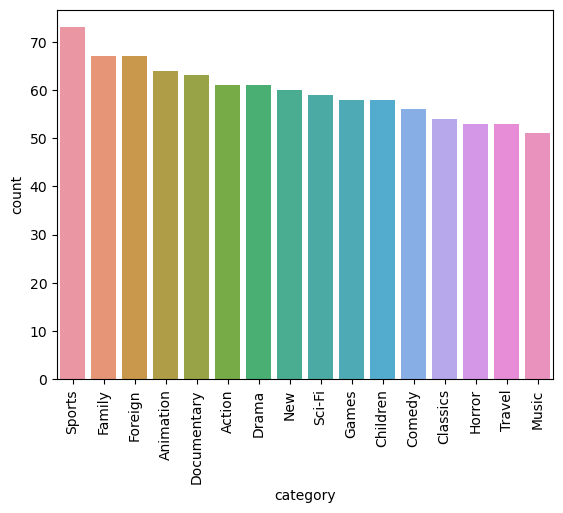

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x=data.category, order=list(data.category.value_counts().index));
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees for better visibility
plt.show()

In [27]:
data.rating.value_counts()

PG-13    213
NC-17    202
R        189
PG       183
G        171
Name: rating, dtype: int64

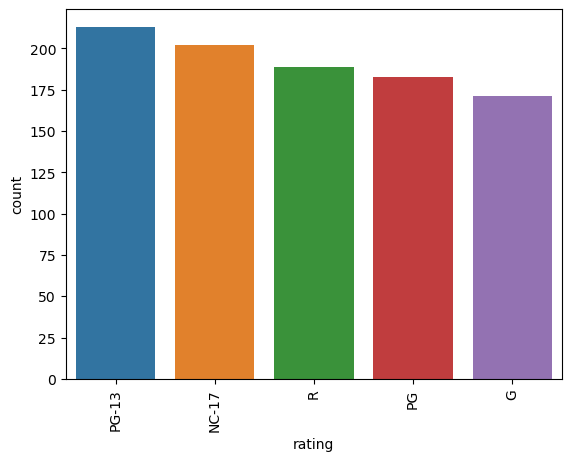

In [28]:
sns.countplot(x=data.rating, order=list(data.rating.value_counts().index));
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees for better visibility
plt.show()

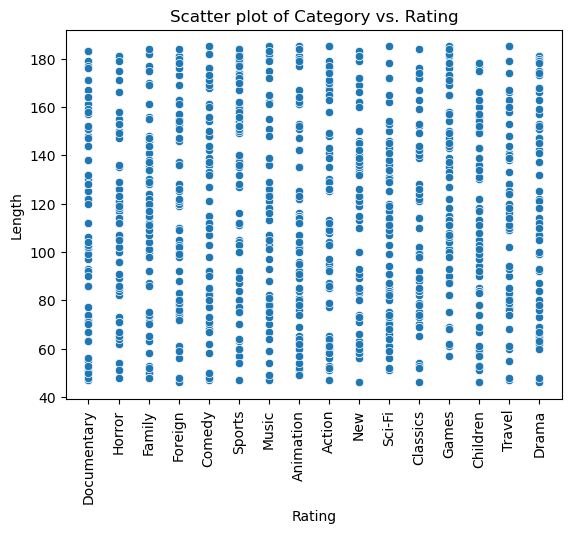

In [34]:
sns.scatterplot(x='category', y='length', data=data)
plt.xticks(rotation=90) 
plt.title('Scatter plot of Category vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Length')
plt.show()

/var/folders/qk/1vyqczmd3c30kgcpdk2v9wfw0000gn/T/ipykernel_58709/3597185393.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=data.corr(method='pearson')  # default


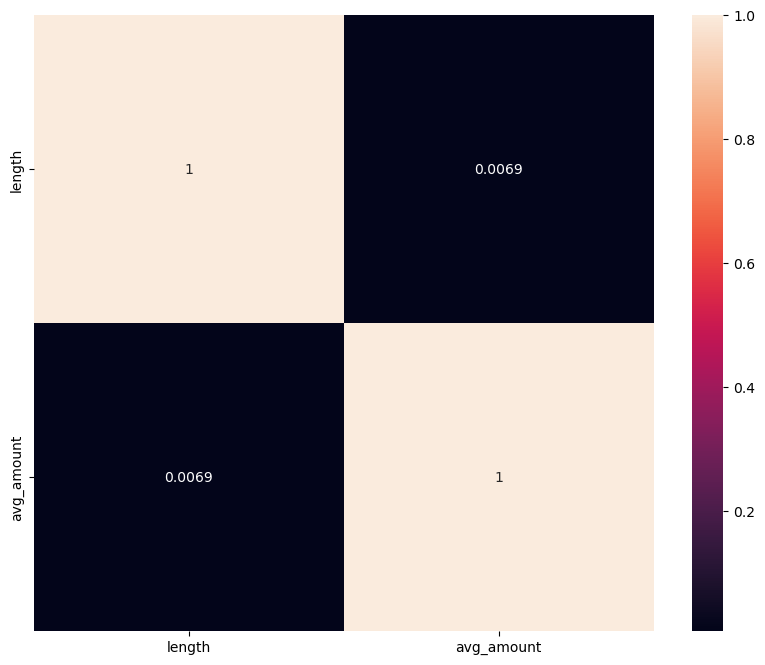

In [35]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

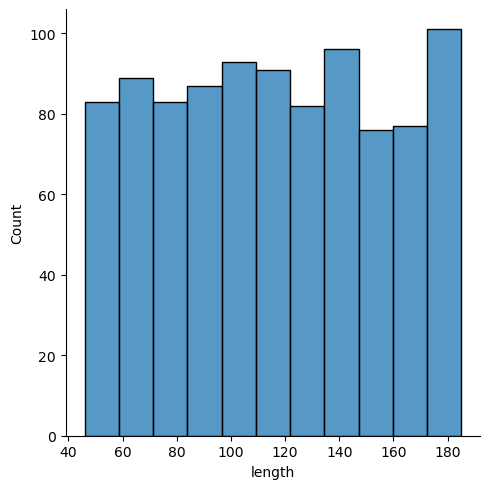

In [36]:
sns.displot(data['length'])
plt.show()

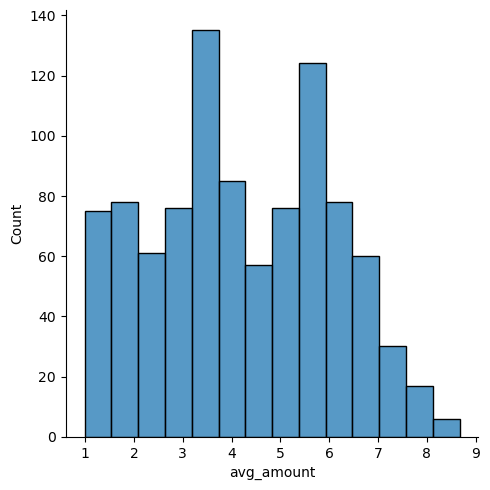

In [37]:
sns.displot(data['avg_amount'])
plt.show()

In [45]:
# X, Y train split
y = data['rented_in_may']
X = data.drop(['rented_in_may', 'title'], axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [46]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)
X_test_num  = X_test.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer

X_train_normalized = transformer.transform(X_train_num)
X_test_normalized  = transformer.transform(X_test_num)

X_train_norm = pd.DataFrame(X_train_normalized, columns=X_train_num.columns)
X_test_norm  = pd.DataFrame(X_test_normalized, columns=X_test_num.columns)

In [47]:
X_train_norm.describe()

,length,avg_amount
count,766.000000,766.000000
mean,0.506199,0.421442
std,0.290413,0.240730
min,0.000000,0.000000
25%,0.253597,0.234375
50%,0.510791,0.395182
75%,0.748201,0.618490
max,1.000000,1.000000


In [49]:
X_train_categorical = X_train.select_dtypes('object')
X_test_categorical  = X_test.select_dtypes('object')

from sklearn.preprocessing import OneHotEncoder

#categories_values = [list(data[col].unique()) for col in X_train_categorical.columns]
encoder = OneHotEncoder(drop='first')
encoder.fit(X_train_categorical)

X_train_cat_np = encoder.transform(X_train_categorical).toarray()
X_test_cat_np  = encoder.transform(X_test_categorical).toarray()

X_train_cat = pd.DataFrame(X_train_cat_np, columns=encoder.get_feature_names_out())
X_test_cat  = pd.DataFrame(X_test_cat_np,  columns=encoder.get_feature_names_out())
X_train_cat.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


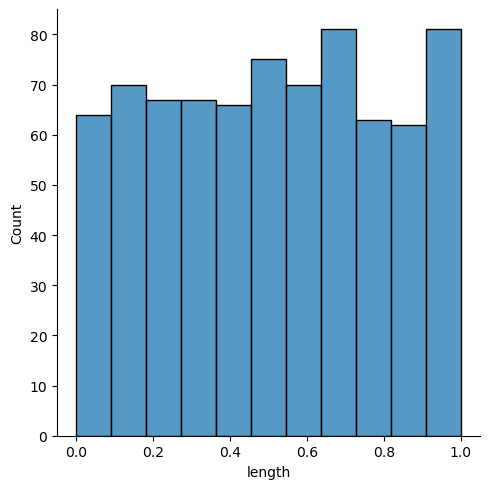

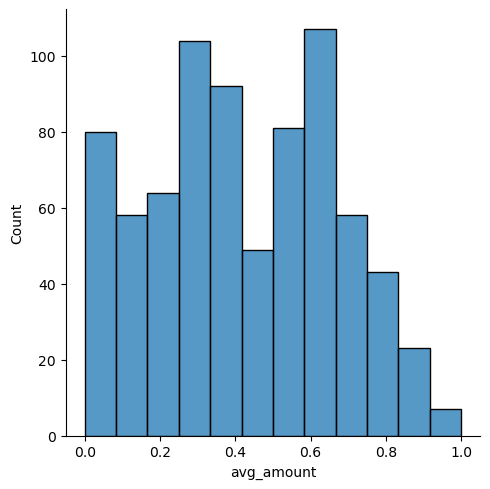

In [52]:
sns.displot(X_train_norm['length'])
plt.show()
sns.displot(X_train_norm['avg_amount'])
plt.show()

In [53]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [54]:
X_train_transformed

array([[0.41007194, 0.21744792, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05035971, 0.22526042, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.20143885, 0.40885417, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.76258993, 0.70963542, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.43165468, 0.25390625, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.35251799, 0.45833333, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [56]:
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial')

classification.fit(X_train_transformed, y_train)

LogisticRegression(multi_class='multinomial', random_state=0, solver='saga')

In [57]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [60]:
# Now we can make predictions on the test set:
y_test_pred = classification.predict(X_test_transformed)
print(y_test_pred)

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,y_test_pred))
classification.score(X_test_transformed, y_test) # Accuracy for classification models and R2 for regression mnodels

['Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Y

0.734375

In [61]:
print(y_test.value_counts()) # inbalance between 'Yes' and 'No'

Yes    141
No      51
Name: rented_in_may, dtype: int64


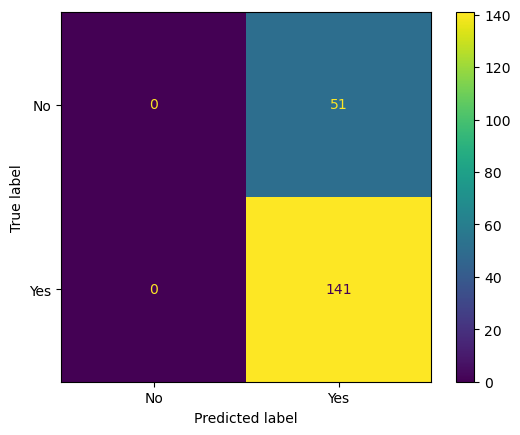

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_)
disp.plot()
plt.show()

In [66]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_test_pred)

0.0

In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          No       0.00      0.00      0.00        51
         Yes       0.73      1.00      0.85       141

    accuracy                           0.73       192
   macro avg       0.37      0.50      0.42       192
weighted avg       0.54      0.73      0.62       192



/Users/ugoejiofor/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ugoejiofor/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ugoejiofor/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
